# Austin Weather — Precipitation Prediction and EDA

**Project overview:**  
Load the Austin weather dataset, clean it by removing irrelevant columns and handling missing values and symbols (like `"T"` for trace precipitation or `"-"` for missing), preprocess features, train a Linear Regression model (scikit-learn) to predict `PrecipitationSumInches`, and analyze relationships between precipitation and weather attributes. Visualize trends and correlations using `matplotlib` and `seaborn`.  

> This notebook is structured with clear headings, comments, and ready-to-run cells.  
**Assumption:** the dataset file is named `austin_weather.csv` and is placed in the same folder as this notebook. If your filename differs, update the path in the first code cell.  


In [1]:
# Cell: Imports and load dataset
# Standard imports used across the notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os

# Adjust display options for pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

# Path to dataset (change if necessary)
csv_path = 'austin_weather.csv'

if not os.path.exists(csv_path):
    print(f"Warning: '{csv_path}' not found in the working directory.\nPlease place the CSV in the same folder or update csv_path.")
else:
    print(f"Found dataset: {csv_path}")

# Load with pandas (no parsing yet — we'll inspect columns next)
try:
    df = pd.read_csv(csv_path)
except Exception as e:
    # If reading fails, show helpful message; user can adapt this cell
    print('Error reading CSV — please check file and path:', e)
    df = pd.DataFrame()

# Show top rows and columns
df.head(), df.shape


Found dataset: austin_weather.csv


(         Date  TempHighF  TempAvgF  TempLowF DewPointHighF DewPointAvgF DewPointLowF HumidityHighPercent  \
 0  2013-12-21         74        60        45            67           49           43                  93   
 1  2013-12-22         56        48        39            43           36           28                  93   
 2  2013-12-23         58        45        32            31           27           23                  76   
 3  2013-12-24         61        46        31            36           28           21                  89   
 4  2013-12-25         58        50        41            44           40           36                  86   
 
   HumidityAvgPercent HumidityLowPercent SeaLevelPressureHighInches SeaLevelPressureAvgInches  \
 0                 75                 57                      29.86                     29.68   
 1                 68                 43                      30.41                     30.13   
 2                 52                 27             

## Inspecting columns and initial cleanup
Look at the column names and a few rows to decide which columns are relevant. We'll keep typical weather indicators: temperature averages, humidity, wind speed, pressure, precipitation fields, and date/time. Remove obviously irrelevant columns (IDs, comments, station names if not needed).

In [2]:
# Inspect columns and sample rows (run this to see what's inside)
print('Columns:', list(df.columns))
print('\nData types:\n', df.dtypes.value_counts())
df.sample(5)


Columns: ['Date', 'TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF', 'DewPointAvgF', 'DewPointLowF', 'HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent', 'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches', 'SeaLevelPressureLowInches', 'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles', 'WindHighMPH', 'WindAvgMPH', 'WindGustMPH', 'PrecipitationSumInches', 'Events']

Data types:
 object    18
int64      3
Name: count, dtype: int64


,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
400,2015-01-25,73,57,40,40,34,29,85,53,20,30.2,30.11,30.02,10,10,10,13,6,20,0,
159,2014-05-29,89,78,66,65,63,61,93,66,38,29.89,29.85,29.79,10,10,10,9,2,15,0,
842,2016-04-11,89,80,70,71,68,66,93,74,55,29.98,29.89,29.83,10,10,6,15,5,26,T,
1253,2017-05-27,97,87,76,76,74,72,94,71,48,29.91,29.85,29.76,10,6,2,15,7,23,0.01,Rain
1271,2017-06-14,96,87,78,74,71,67,85,63,41,29.99,29.9,29.83,10,10,7,14,8,23,0,


## Cleaning steps — handling trace values and missing symbols

Common issues in weather datasets:
- `'T'` often denotes a *trace* amount of precipitation. Options: treat as a small positive value (e.g., `0.001`) or as `0.0`. We'll treat it as `0.0` by default but show how to change it.
- `'-'` or other non-numeric symbols often mean missing — convert to `NaN`.
- Convert numeric columns that are stored as strings to numeric types using `pd.to_numeric(..., errors='coerce')`.
- Drop or fill missing values sensibly. For modeling we'll drop rows with missing target (`PrecipitationSumInches`) and impute or drop other missing values depending on count.
- Parse the date column into `datetime` if present for time series plots.


In [3]:
# Cleaning function with common conversions and safety checks
def clean_weather_df(df, date_col_candidates=None, precip_col='PrecipitationSumInches', trace_value=0.0):
    df = df.copy()
    # 1) Normalize column names (strip)
    df.columns = [c.strip() for c in df.columns]
    
    # 2) Identify date column if given list or guess common names
    if date_col_candidates is None:
        date_col_candidates = ['DATE', 'Date', 'date', 'datetime', 'Time', 'time']
    date_col = None
    for c in date_col_candidates:
        if c in df.columns:
            date_col = c
            break
    
    if date_col is not None:
        # Parse datetime if possible
        try:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        except Exception:
            pass
    else:
        date_col = None
    
    # 3) Replace common missing symbols: '-' -> NaN, empty strings -> NaN, 'T' -> trace_value for precipitation columns
    df.replace('-', np.nan, inplace=True)
    df.replace('', np.nan, inplace=True)
    
    # If precipitation column exists, replace 'T' there only (safe approach)
    if precip_col in df.columns:
        df[precip_col] = df[precip_col].replace('T', trace_value)
    
    # 4) Convert all columns that look numeric but stored as object to numeric
    for col in df.columns:
        if df[col].dtype == 'object':
            # try converting
            df[col] = df[col].str.replace(',', '').str.strip()  # remove commas and extra spaces
            df[col] = pd.to_numeric(df[col], errors='ignore')
            # if still object, try coercing to numeric to force NaNs on non-convertible
            if df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 5) Ensure precipitation column numeric
    if precip_col in df.columns:
        df[precip_col] = pd.to_numeric(df[precip_col], errors='coerce')
    
    # 6) Return cleaned df and the date column name (if any)
    return df, date_col

# Apply cleaning
df_clean, date_col = clean_weather_df(df, date_col_candidates=['DATE','Date','date','datetime','Time','time','DATE (MM/DD/YYYY)'], precip_col='PrecipitationSumInches', trace_value=0.0)

print('After cleaning: shape =', df_clean.shape)
df_clean.dtypes.value_counts()


After cleaning: shape = (1319, 21)


C:\Users\hp\AppData\Local\Temp\ipykernel_16444\1105204112.py:38: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


float64           17
int64              3
datetime64[ns]     1
Name: count, dtype: int64

### Handling missing values and previewing the target distribution

Decisions:
- We must have a numeric `PrecipitationSumInches` for modeling. We'll drop rows missing the target.
- For input features we can either impute (mean/median) or drop columns/rows with too many missing values. We'll show a simple approach: drop columns with >50% missing, then impute remaining numeric features with median.


In [4]:
# Check missing value ratios
missing_ratio = df_clean.isna().mean().sort_values(ascending=False)
missing_ratio[missing_ratio > 0].head(20)

# Drop columns with >50% missing
cols_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()
print('Dropping columns with >50% missing:', cols_to_drop)
df_clean = df_clean.drop(columns=cols_to_drop)

# Drop rows with missing target
target = 'PrecipitationSumInches'
df_clean = df_clean[~df_clean[target].isna()].copy()
print('After dropping rows with missing target:', df_clean.shape)

# Separate numeric features and impute remaining NaNs with median
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(target) if target in numeric_cols else None
print('Numeric features considered for modeling:', numeric_cols)

# Impute numeric missing values with median (simple and robust)
for col in numeric_cols:
    med = df_clean[col].median()
    if pd.isna(med):
        # if column all NaN, drop it
        df_clean.drop(columns=[col], inplace=True)
    else:
        df_clean[col].fillna(med, inplace=True)

print('Final shape after imputation:', df_clean.shape)


Dropping columns with >50% missing: ['Events']
After dropping rows with missing target: (1195, 20)
Numeric features considered for modeling: ['TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF', 'DewPointAvgF', 'DewPointLowF', 'HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent', 'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches', 'SeaLevelPressureLowInches', 'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles', 'WindHighMPH', 'WindAvgMPH', 'WindGustMPH']
Final shape after imputation: (1195, 20)


C:\Users\hp\AppData\Local\Temp\ipykernel_16444\1681557626.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(med, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_16444\1681557626.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

## Feature selection and preprocessing for Linear Regression

Choose sensible features related to precipitation (or allow user to select). Common features:
- `AverageTemperature`, `MeanTemperature`, `MaxTemperature`, `MinTemperature` (use available name)
- Humidity: `RelativeHumidity`, `HumidityAvg`
- Wind: `WindSpeedAvg`, `WindSpeed`, `WindGust`
- Pressure: `SeaLevelPressure` or similar
- `CloudCover`, `DewPoint`

We'll automatically pick numeric columns (excluding the target and time-related columns) and allow the user to override by editing the `features` list in the cell.


In [5]:
# Auto-select numeric features (excluding target and the date column)
all_numeric = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target in all_numeric:
    all_numeric.remove(target)
if date_col and date_col in all_numeric:
    all_numeric.remove(date_col)

# Suggest features (you can modify this list)
print('Auto-detected numeric columns:', all_numeric)

# Default to using all numeric columns as features; user can edit the list below
features = all_numeric.copy()
print('Using features:', features)

# Prepare X and y
X = df_clean[features].copy()
y = df_clean[target].copy()

# Quick sanity check
print('X shape:', X.shape, 'y shape:', y.shape)
X.head()


Auto-detected numeric columns: ['TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF', 'DewPointAvgF', 'DewPointLowF', 'HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent', 'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches', 'SeaLevelPressureLowInches', 'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles', 'WindHighMPH', 'WindAvgMPH', 'WindGustMPH']
Using features: ['TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF', 'DewPointAvgF', 'DewPointLowF', 'HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent', 'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches', 'SeaLevelPressureLowInches', 'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles', 'WindHighMPH', 'WindAvgMPH', 'WindGustMPH']
X shape: (1195, 18) y shape: (1195,)


,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH
0,74,60,45,67.0,49.0,43.0,93.0,75.0,57.0,29.86,29.68,29.59,10.0,7.0,2.0,20.0,4.0,31.0
1,56,48,39,43.0,36.0,28.0,93.0,68.0,43.0,30.41,30.13,29.87,10.0,10.0,5.0,16.0,6.0,25.0
2,58,45,32,31.0,27.0,23.0,76.0,52.0,27.0,30.56,30.49,30.41,10.0,10.0,10.0,8.0,3.0,12.0
3,61,46,31,36.0,28.0,21.0,89.0,56.0,22.0,30.56,30.45,30.30,10.0,10.0,7.0,12.0,4.0,20.0
5,57,48,39,39.0,36.0,33.0,79.0,63.0,47.0,30.47,30.40,30.34,10.0,9.0,7.0,12.0,3.0,17.0


## Modeling — Linear Regression with scikit-learn

We will:
1. Split data into train/test sets (80/20)
2. Standardize features
3. Fit `LinearRegression`
4. Evaluate using RMSE, MAE, and R²
5. Show coefficients to understand which features influence precipitation


In [6]:
# Split, scale, fit, evaluate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for coefficients interpretation and numerical stability)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}')

# Coefficients (map back to feature names using scaler scale)
coef = pd.Series(model.coef_, index=features)
coef_sorted = coef.sort_values(key=abs, ascending=False)
print('\nTop coefficients (by absolute value):')
coef_sorted.head(10)


RMSE: 0.4272 | MAE: 0.2030 | R2: 0.3509

Top coefficients (by absolute value):


TempAvgF             -1.166851
TempHighF             0.721413
TempLowF              0.662724
DewPointAvgF         -0.534821
DewPointLowF          0.207536
DewPointHighF         0.161770
HumidityLowPercent    0.152647
WindHighMPH           0.142353
VisibilityAvgMiles   -0.116971
WindAvgMPH           -0.091622
dtype: float64

## Visualizations

We'll produce:
- Actual vs Predicted scatter plot (to check fit)
- Time series of precipitation (if date column exists)
- Correlation heatmap between selected features and precipitation
- Residual plot to inspect errors


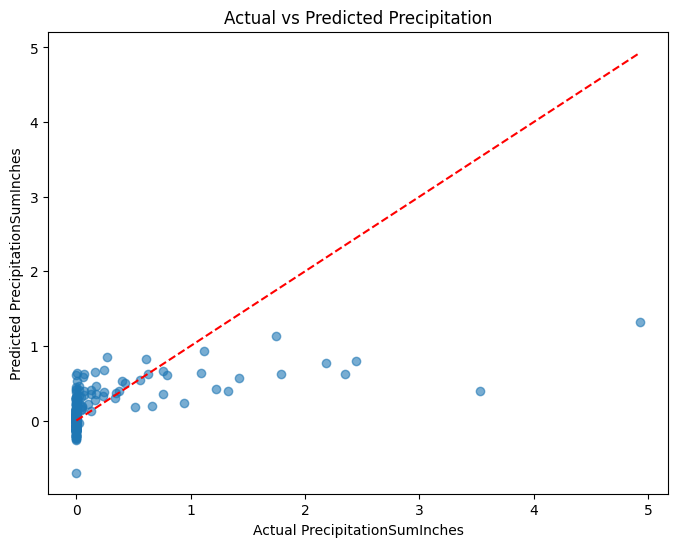

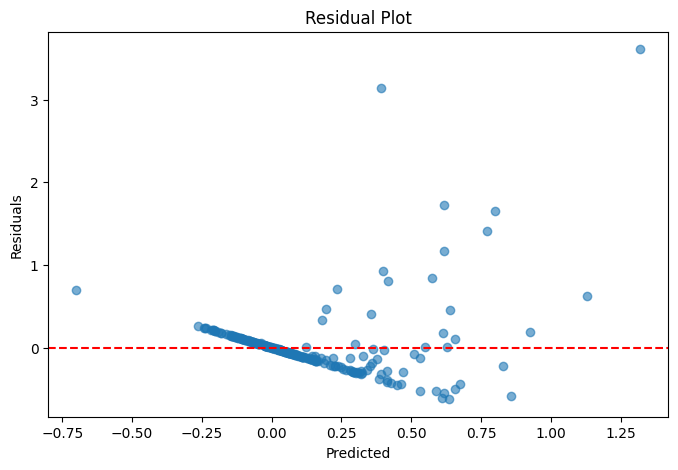

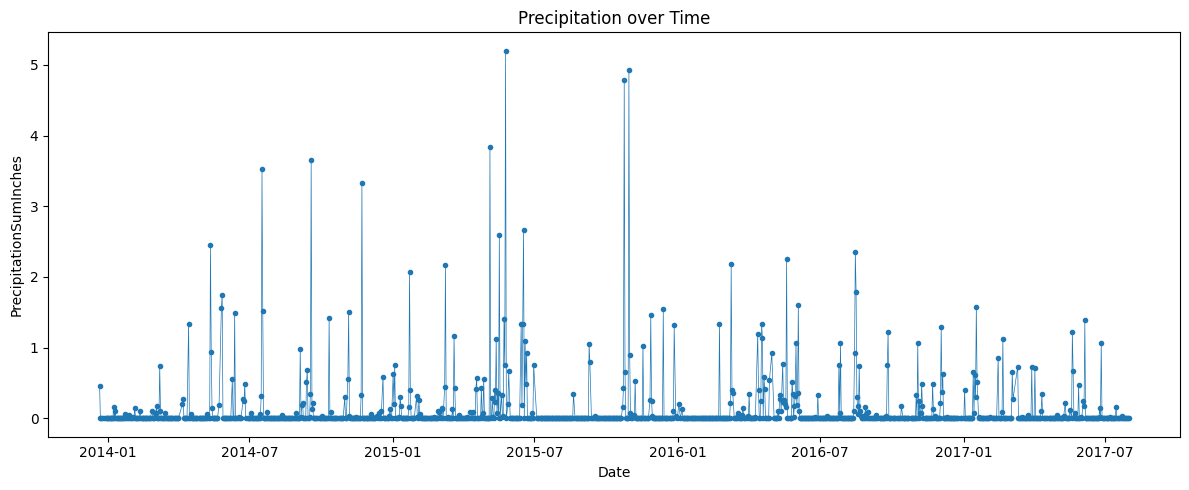

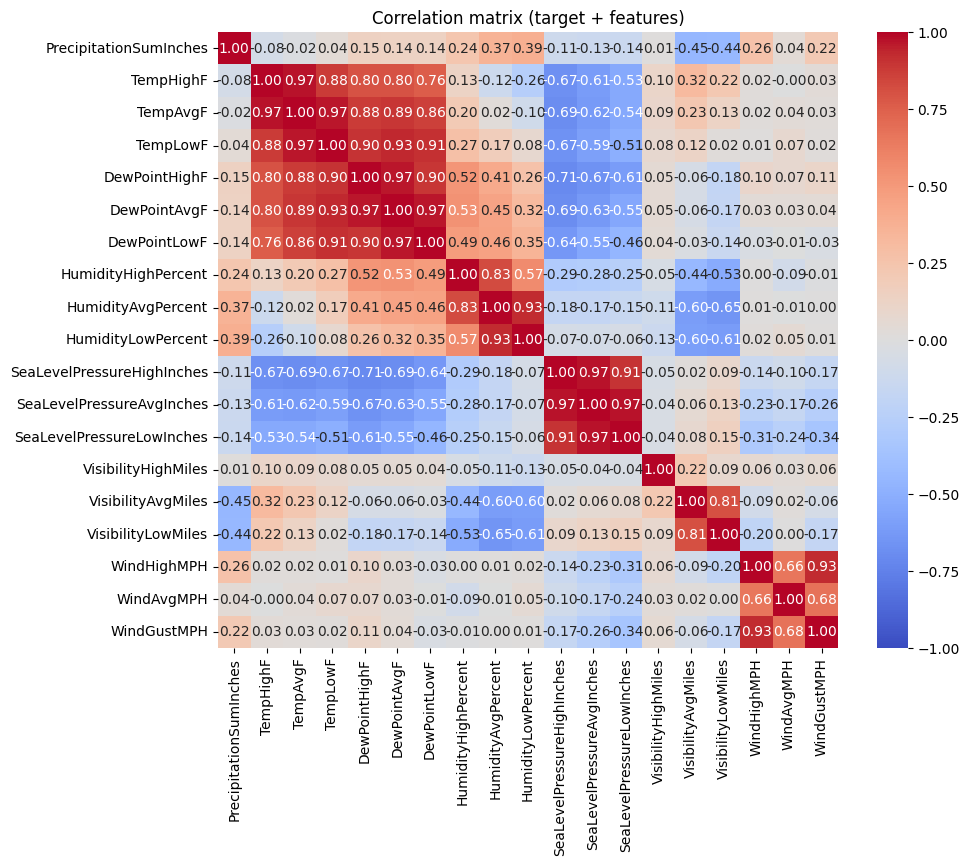

In [7]:
# Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual PrecipitationSumInches')
plt.ylabel('Predicted PrecipitationSumInches')
plt.title('Actual vs Predicted Precipitation')
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Time series precipitation (if date available)
if date_col and date_col in df_clean.columns:
    ts = df_clean[[date_col, target]].dropna().sort_values(by=date_col)
    plt.figure(figsize=(12,5))
    plt.plot(ts[date_col], ts[target], marker='.', linewidth=0.5)
    plt.xlabel('Date')
    plt.ylabel('PrecipitationSumInches')
    plt.title('Precipitation over Time')
    plt.tight_layout()
    plt.show()
else:
    print('No date column parsed — skipping time series plot.')

# Correlation heatmap (features + target)
plt.figure(figsize=(10,8))
corr = df_clean[[target] + features].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix (target + features)')
plt.show()


## Conclusion & Next steps

- We built a simple linear regression model to predict precipitation.
- Check metrics (RMSE, MAE, R²) to see how good the linear model is.
- Next steps to improve:
  - Feature engineering (lagged precipitation, rolling means, interaction terms)
  - Use tree-based models or regularized models (Ridge/Lasso) to handle collinearity
  - Time-series specific models if temporal dependence is strong (ARIMA, Prophet, LSTM)
  - Better handling for `'T'` (trace precipitation) if domain knowledge suggests a different treatment
